In [194]:
import os
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline
sns.set_style(None,{"font.sans-serif":['simhei', 'Arial']})

pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
orders = pd.read_csv('/Users/yichingchan/Documents/91APP/NTU_大數據與商業分析Datasets/Orders.csv')
df_orders = orders.copy()

In [3]:
member = pd.read_csv('/Users/yichingchan/Documents/91APP/NTU_大數據與商業分析Datasets/Member.csv')
df_members = member.copy()

In [4]:
df_orders['mean_payment'] = df_orders['SalesOrderSlaveTotalPayment'] / df_orders['Quantity']

------

In [5]:
#drop city name if unrecognizable 
weird_name = ['1st','<fo','New', 'Nan','Tao','Tai','25','Hy','Quậ','Xin','Kao','No.', 'Hsi','Jia','Kot','Ins','Aya','Daf','Keb','Đại','Cha']
index_drop = []
for i, val in df_orders['City'].iteritems():
    if val in weird_name:
        index_drop.append(i)        
df_orders.drop(index_drop , inplace=True)

In [6]:
#DateId轉換成datetime
df_orders['DateId'] = pd.to_datetime(df_orders['SalesOrderSlaveDateTime'])
df_orders['DateId'] = df_orders['DateId'].dt.date
df_orders['DateId'] = pd.to_datetime(df_orders['DateId'])

In [7]:
#transactions for each member by date
df_orders = df_orders[(df_orders['IsGift'] == False) & (df_orders['IsMajor'] == True) & (df_orders['StatusDef'] == 'Finish')]
df_all = df_orders.groupby(['DateId','MemberId','OrderGroupCode'])['Quantity', 'SalesOrderSlaveTotalPayment'].sum().reset_index()
df_all = df_all.groupby(['DateId','MemberId'])['Quantity', 'SalesOrderSlaveTotalPayment'].sum().reset_index()
#df_all['DateId'] = df_all['DateId'].dt.date
df_all.head()

,DateId,MemberId,Quantity,SalesOrderSlaveTotalPayment
0,2015-05-06,192540,6,1357.0
1,2015-05-06,205786,5,1033.0
2,2015-05-06,297791,1,299.0
3,2015-05-06,403195,1,299.0
4,2015-05-06,808449,6,1194.0


In [8]:
def f(row):
    fre_lst = []
    lst = row['DateId'] 
    for i in range(len(lst)):
        if i == 0:
            continue
        else:
            delta = lst[i] - lst[i-1]
        fre_lst.append(delta.days)
    return fre_lst

def mean(row):
    lst = row['frequency'] 
    mean = np.mean(np.array(lst))
    return mean

def std(row):
    lst = row['frequency'] 
    std = np.std(np.array(lst))
    return std


def label(row):
    q = row['Quantity']
    p = row['mean_payment']
    if (p>p75) & (q>q75):
         label = 'A'
    elif (p>p50) & (q>q50):
        label = 'B'
    elif (p>p50) & (q<=q50):
        label = 'C'
    elif (p<=p50) & (q>q50):
        label = 'D'
    elif (p<=p25) & (q<=q25):
        label = 'F'
    else:
        label = 'E'
    return label    
    
def ctrbn(row):
    ctrbn = row['SalesOrderSlaveTotalPayment']
    if ctrbn>c80:
        rank = 'tier 1'
    elif c60<ctrbn<=c80:
        rank = 'tier 2'
    elif c40<ctrbn<=c60:
        rank = 'tier 3'
    elif c20<ctrbn<=c40:
        rank = 'tier 4'
    else:
        rank = 'tier 5'
    return rank

    
    
def get_label(df_orders, df_all, start, end):
    
    #customer segmentation
    orders = df_orders[(df_orders['DateId'] >= start) & (df_orders['DateId'] <= end)]
    q_rank = orders.groupby('MemberId', as_index = False)['Quantity'].sum()
    p_rank = orders.groupby('MemberId', as_index = False)['mean_payment'].mean()
    ctrbn_rank = orders.groupby('MemberId', as_index = False)['SalesOrderSlaveTotalPayment'].sum()
    qp = pd.merge(q_rank, p_rank, on='MemberId', how='left')
    qp = pd.merge(qp, ctrbn_rank, on='MemberId', how='left')

    q25 = np.quantile(qp['Quantity'],0.25)
    q50= np.quantile(qp['Quantity'],0.5)
    q75 = np.quantile(qp['Quantity'],0.75)

    p25 = np.quantile(qp['mean_payment'],0.25)
    p50= np.quantile(qp['mean_payment'],0.5)
    p75 = np.quantile(qp['mean_payment'],0.75)
    
    c20 = np.quantile(qp['SalesOrderSlaveTotalPayment'],0.2)
    c40= np.quantile(qp['SalesOrderSlaveTotalPayment'],0.4)
    c60 = np.quantile(qp['SalesOrderSlaveTotalPayment'],0.6)
    c80 = np.quantile(qp['SalesOrderSlaveTotalPayment'],0.8)

    
    def label(row):
        q = row['Quantity']
        p = row['mean_payment']
        if (p>p75) & (q>q75):
             label = 'A'
        elif (p>p50) & (q>q50):
            label = 'B'
        elif (p>p50) & (q<=q50):
            label = 'C'
        elif (p<=p50) & (q>q50):
            label = 'D'
        elif (p<=p25) & (q<=q25):
            label = 'F'
        else:
            label = 'E'
        return label    
    
    def ctrbn(row):
        ctrbn = row['SalesOrderSlaveTotalPayment']
        if ctrbn>c80:
            rank = 'tier 1'
        elif c60<ctrbn<=c80:
            rank = 'tier 2'
        elif c40<ctrbn<=c60:
            rank = 'tier 3'
        elif c20<ctrbn<=c40:
            rank = 'tier 4'
        else:
            rank = 'tier 5'
        return rank
    
    qp['label'] = qp.apply(label, axis=1)
    qp['ctrbn'] = qp.apply(ctrbn, axis=1)
        
            
    #frequency
    df_all['DateId'] = pd.to_datetime(df_all['DateId'])
    df = df_all[(df_all['DateId'] >= start) & (df_all['DateId'] <= end)]
    fre = df.groupby('MemberId')['DateId'].apply(list).reset_index()
    fre['frequency'] = fre.apply(f,axis=1)
    fre['frequency_mean'] = fre.apply(mean,axis=1) #看平均，因為需要考慮到極端值
    fre['frequency_std'] = fre.apply(std,axis=1)
    
    return fre, qp

In [9]:
fre_all, qp_all = get_label(df_orders, df_all, '2015-05-06', '2018-04-15')
fre15, qp15 = get_label(df_orders, df_all, '2015-05-06', '2016-04-30')
fre16, qp16 = get_label(df_orders, df_all, '2016-05-01', '2017-04-30')
fre17, qp17 = get_label(df_orders, df_all, '2017-05-01', '2018-04-15')

fre_all = pd.merge(fre_all, qp_all[['MemberId', 'Quantity', 'mean_payment', 'SalesOrderSlaveTotalPayment','label']], on='MemberId', how='left')
fre_all = pd.merge(fre_all, qp15[['MemberId', 'label']], on='MemberId', how='left')
fre_all = pd.merge(fre_all, qp16[['MemberId', 'label']], on='MemberId', how='left')
fre_all = pd.merge(fre_all, qp17[['MemberId', 'label']], on='MemberId', how='left')

fre_all = pd.merge(fre_all, qp_all[['MemberId', 'ctrbn']], on='MemberId', how='left')
fre_all = pd.merge(fre_all, qp15[['MemberId', 'ctrbn']], on='MemberId', how='left')
fre_all = pd.merge(fre_all, qp16[['MemberId', 'ctrbn']], on='MemberId', how='left')
fre_all = pd.merge(fre_all, qp17[['MemberId', 'ctrbn']], on='MemberId', how='left')

fre_all.columns = ['MemberId', 'DateId', 'frequency', 'frequency_mean', 'frequency_std',
       'Quantity','mean_payment', 'SalesOrderSlaveTotalPayment', 'label', 'label_yr1',
       'label_yr2', 'label_yr3','ctrbn', 'ctrbn_yr1', 'ctrbn_yr2', 'ctrbn_yr3']
fre_all

,MemberId,DateId,frequency,frequency_mean,frequency_std,Quantity,mean_payment,SalesOrderSlaveTotalPayment,label,label_yr1,label_yr2,label_yr3,ctrbn,ctrbn_yr1,ctrbn_yr2,ctrbn_yr3
0,1362,[2016-11-11 00:00:00],[],NaN,NaN,4,147.750000,591.0,E,NaN,E,NaN,tier 5,NaN,tier 5,NaN
1,1384,"[2016-04-08 00:00:00, 2016-10-20 00:00:00, 201...","[195, 375]",285.000000,90.000000,6,311.333333,1868.0,B,E,C,C,tier 2,tier 4,tier 5,tier 4
2,1391,"[2015-11-11 00:00:00, 2017-11-14 00:00:00, 201...","[734, 118, 30]",294.000000,313.194295,23,243.913043,5610.0,B,E,NaN,B,tier 1,tier 4,NaN,tier 1
3,1400,[2016-12-28 00:00:00],[],NaN,NaN,2,399.000000,798.0,C,NaN,C,NaN,tier 4,NaN,tier 4,NaN
4,1423,[2015-06-05 00:00:00],[],NaN,NaN,3,136.500000,373.0,F,F,NaN,NaN,tier 5,tier 5,NaN,NaN
5,1448,"[2015-11-17 00:00:00, 2015-11-26 00:00:00, 201...","[9, 34, 85, 72, 66, 297]",93.833333,94.324646,29,257.000000,7453.0,B,A,B,D,tier 1,tier 1,tier 2,tier 2
6,1469,"[2015-07-09 00:00:00, 2015-07-20 00:00:00, 201...","[11, 23, 32, 21, 31, 233, 23, 68, 77]",57.666667,65.420011,27,250.703704,6769.0,B,B,A,NaN,tier 1,tier 1,tier 1,NaN
7,1474,[2017-03-22 00:00:00],[],NaN,NaN,3,178.333333,535.0,F,NaN,F,NaN,tier 5,NaN,tier 5,NaN
8,1490,"[2015-12-29 00:00:00, 2016-01-28 00:00:00, 201...","[30, 125]",77.500000,47.500000,14,220.785714,3091.0,D,B,E,NaN,tier 1,tier 1,tier 4,NaN
9,1498,[2015-06-12 00:00:00],[],NaN,NaN,6,195.166667,1171.0,D,D,NaN,NaN,tier 3,tier 2,NaN,NaN


In [10]:
def Npurchase(row):
    times = row['DateId']
    n = len(times)
    return n

fre_all['count'] = fre_all.apply(Npurchase, axis=1)

In [11]:
fre_all[fre_all['frequency_mean'].notnull()]['frequency_mean'].describe()

count    199740.000000
mean        149.825833
std         146.939873
min           1.000000
25%          50.500000
50%         104.400000
75%         196.000000
max        1040.000000
Name: frequency_mean, dtype: float64

In [12]:
np.quantile(fre_all[fre_all['frequency_mean'].notnull()]['frequency_mean'], 0.8)

229.0

In [13]:
df_label = fre_all[['MemberId','label','label_yr1','label_yr2', 'label_yr3']]

In [299]:
df_tier = fre_all[['MemberId','ctrbn_yr1','ctrbn_yr2', 'ctrbn_yr3','ctrbn']]
df_tier.columns = ['MemberId',  'year1', 'year2', 'year3', 'ctrbn']
df_tier.head()

,MemberId,year1,year2,year3,ctrbn
0,1362,NaN,tier 5,NaN,tier 5
1,1384,tier 4,tier 5,tier 4,tier 2
2,1391,tier 4,NaN,tier 1,tier 1
3,1400,NaN,tier 4,NaN,tier 4
4,1423,tier 5,NaN,NaN,tier 5


In [15]:
df_tier = fre_all[['MemberId','ctrbn','ctrbn_yr1','ctrbn_yr2', 'ctrbn_yr3']]
de = df_tier.shape[0]

TTT = (df_tier['ctrbn_yr1'].notnull()) & (df_tier['ctrbn_yr2'].notnull()) & (df_tier['ctrbn_yr3'].notnull())
TFT = (df_tier['ctrbn_yr1'].notnull()) & (df_tier['ctrbn_yr2'].isnull()) & (df_tier['ctrbn_yr3'].notnull())
TTF = (df_tier['ctrbn_yr1'].notnull()) & (df_tier['ctrbn_yr2'].notnull()) & (df_tier['ctrbn_yr3'].isnull())
FTT = (df_tier['ctrbn_yr1'].isnull()) & (df_tier['ctrbn_yr2'].notnull()) & (df_tier['ctrbn_yr3'].notnull())
TFF = (df_tier['ctrbn_yr1'].notnull()) & (df_tier['ctrbn_yr2'].isnull()) & (df_tier['ctrbn_yr3'].isnull())
FTF = (df_tier['ctrbn_yr1'].isnull()) & (df_tier['ctrbn_yr2'].notnull()) & (df_tier['ctrbn_yr3'].isnull())
FFT = (df_tier['ctrbn_yr1'].isnull()) & (df_tier['ctrbn_yr2'].isnull()) & (df_tier['ctrbn_yr3'].notnull())

lst = [('TTT', TTT), ('TFT', TFT), ('TTF', TTF), ('FTT', FTT), ('TFF', TFF), ('FTF', FTF), ('FFT', FFT)]

for tple in lst:
    s = tple[0]
    c = tple[1] 
    print('pctg of %s: %0.2f' % (s, df_tier[c].shape[0]/de))

#TTT/de ,TFT/de, TTF/de, FTT/de, TFF/de, FTF/de, FFT/de #幾乎都只有單年消費

pctg of TTT: 0.05
pctg of TFT: 0.02
pctg of TTF: 0.07
pctg of FTT: 0.10
pctg of TFF: 0.18
pctg of FTF: 0.31
pctg of FFT: 0.27


In [ ]:
5%, 19%, 76%

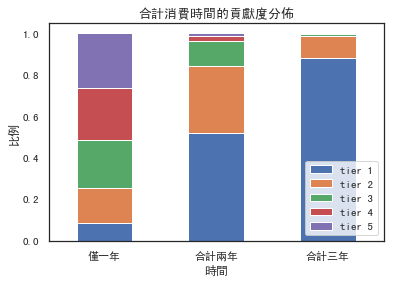

In [331]:
y1 = fre_all[fre_all['MemberId'].isin(df_tier[TFF|FTF | FFT]['MemberId'].tolist())]['ctrbn'].value_counts().to_frame()
y2 = fre_all[fre_all['MemberId'].isin(df_tier[TTF | FTT]['MemberId'].tolist())]['ctrbn'].value_counts().to_frame()
y3 = fre_all[fre_all['MemberId'].isin(df_tier[TTT ]['MemberId'].tolist())]['ctrbn'].value_counts().to_frame()

Y = pd.concat([y1,y2,y3], axis=1)
Y.columns = ['僅一年','合計兩年','合計三年']
#get percentage
Y['僅一年'] = Y['僅一年'] / Y.sum()['僅一年']
Y['合計兩年'] = Y['合計兩年'] / Y.sum()['合計兩年']
Y['合計三年'] = Y['合計三年'] / Y.sum()['合計三年']

Y.transpose().plot(kind='bar', stacked=True)
plt.title('合計消費時間的貢獻度分佈', fontsize=13)
plt.xlabel('時間', fontsize=12)
plt.ylabel('比例', fontsize=12)
plt.xticks(rotation='horizontal')
plt.show()


In [305]:
fre_all[fre_all['MemberId'].isin(df_tier[TFF|FTF | FFT]['MemberId'].tolist())]['ctrbn'].value_counts().to_frame()

tier 5    97832
tier 4    95467
tier 3    85841
tier 2    64320
tier 1    30855
Name: ctrbn, dtype: int64

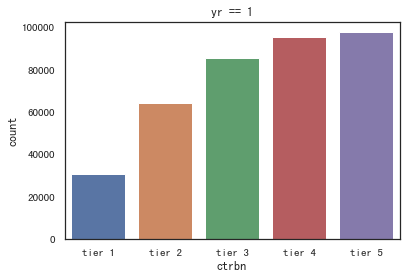

,count,SalesOrderSlaveTotalPayment,Quantity
count,374315.000000,374315.000000,374315.00000
mean,1.350811,1238.986701,5.34016
std,0.881200,1270.434946,5.24511
min,1.000000,1.000000,1.00000
25%,1.000000,598.000000,3.00000
50%,1.000000,887.000000,4.00000
75%,1.000000,1446.000000,6.00000
max,53.000000,97378.000000,314.00000


In [302]:
oneyr_member = df_tier[TFF|FTF | FFT]['MemberId'].tolist()
df = fre_all[fre_all['MemberId'].isin(oneyr_member)]
df['count'].describe()
sns.countplot(data = df, x='ctrbn', order = ['tier 1', 'tier 2', 'tier 3', 'tier 4', 'tier 5'])
plt.title('yr == 1')
plt.show()
df[['count', 'SalesOrderSlaveTotalPayment', 'Quantity']].describe()

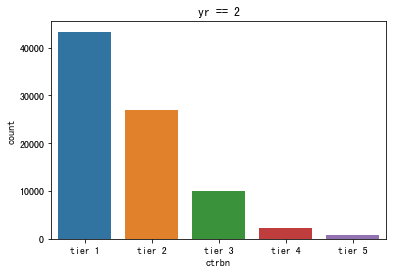

,count,SalesOrderSlaveTotalPayment,Quantity
count,83318.000000,83318.000000,83318.000000
mean,3.767277,3731.646247,16.006169
std,2.742716,3651.875011,14.966087
min,2.000000,170.000000,2.000000
25%,2.000000,1747.000000,8.000000
50%,3.000000,2728.500000,12.000000
75%,4.000000,4473.000000,19.000000
max,84.000000,129728.000000,546.000000


In [17]:
twoyr_member = df_tier[TTF | FTT]['MemberId'].tolist()
df = fre_all[fre_all['MemberId'].isin(twoyr_member)]
df['count'].describe()
sns.countplot(data = df, x='ctrbn', order = ['tier 1', 'tier 2', 'tier 3', 'tier 4', 'tier 5'])
plt.title('yr == 2')
plt.show()
df[['count', 'SalesOrderSlaveTotalPayment', 'Quantity']].describe()

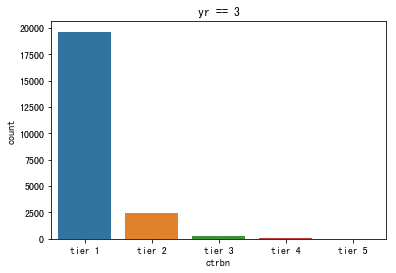

,count,SalesOrderSlaveTotalPayment,Quantity
count,22334.000000,22334.000000,22334.000000
mean,7.297170,7402.279260,31.325692
std,5.164385,6600.034666,26.610247
min,3.000000,451.000000,3.000000
25%,4.000000,3567.250000,15.000000
50%,6.000000,5560.000000,24.000000
75%,9.000000,8917.000000,38.000000
max,97.000000,142552.000000,495.000000


In [18]:
threeyr_member = df_tier[TTT ]['MemberId'].tolist()
df = fre_all[fre_all['MemberId'].isin(threeyr_member)]
df['count'].describe()
sns.countplot(data = df, x='ctrbn', order = ['tier 1', 'tier 2', 'tier 3', 'tier 4', 'tier 5'])
plt.title('yr == 3')
plt.show()
df[['count', 'SalesOrderSlaveTotalPayment', 'Quantity']].describe()

In [19]:
fre_all[fre_all['count'] == 1].shape[0]/fre_all.shape[0]

0.5938848913549573

In [256]:
fre_all[fre_all['count'] == 2].shape[0]/fre_all.shape[0]

0.18964644359546268

In [266]:
fre_all[fre_all['count'] == 3].shape[0]/fre_all.shape[0]

0.08630200211048104

Text(0, 0.5, '人數')

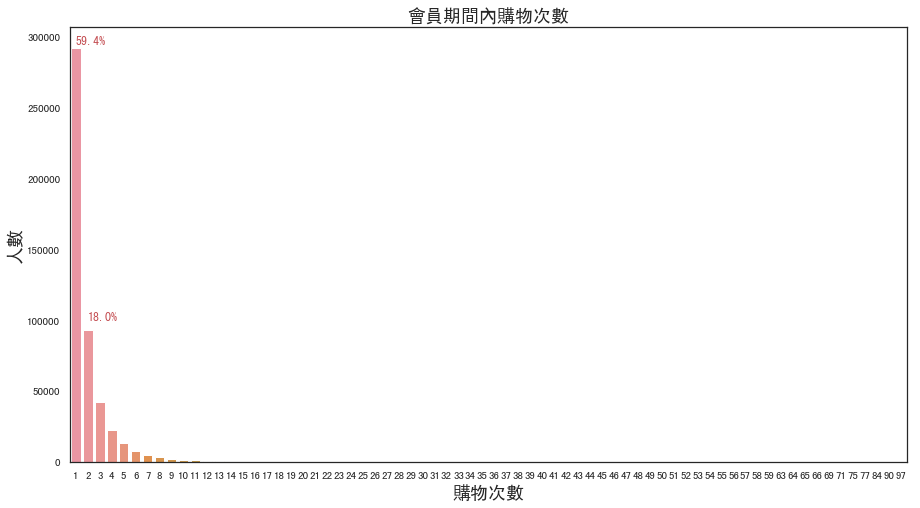

In [265]:
plt.figure(figsize=(15,8))
sns.countplot(data=fre_all, x='count')
plt.annotate('59.4%', xy=(0.00001,295000), color='r')
plt.annotate('18.0%', xy=(1,100000), color='r')
            

plt.title('會員期間內購物次數', fontsize=18)
plt.xlabel('購物次數', fontsize=18)
plt.ylabel('人數', fontsize=18)

In [22]:
np1 = fre_all[fre_all['count'] >= 1].shape[0]
np2 = fre_all[fre_all['count'] >= 2].shape[0]
np3 = fre_all[fre_all['count'] >= 3].shape[0]
np4 = fre_all[fre_all['count'] >= 4].shape[0]
np5 = fre_all[fre_all['count'] >= 5].shape[0]
np6 = fre_all[fre_all['count'] >= 6].shape[0]
np7 = fre_all[fre_all['count'] >= 7].shape[0]
np8 = fre_all[fre_all['count'] >= 8].shape[0]
np9 = fre_all[fre_all['count'] >= 9].shape[0]
np10 = fre_all[fre_all['count'] >= 10].shape[0]

p1 = df_members['MinOrderDate'].isnull().sum()/df_members.shape[0] 
p2 = np2/np1 
p3 = np3/np2
p4 = np4/np3
p5 = np5/np4
p6 = np6/np5
p7 = np7/np6
p8 = np8/np7
p9 = np9/np8
p10 = np10/np9

pct = [p1,p2, p3, p4, p5, p6, p7,p8,p9,p10]
nth_purchase_pct = pd.DataFrame([i for i in range(1,11)])
nth_purchase_pct['pct'] = pct
nth_purchase_pct.columns = ['nth purchase', 'pct']

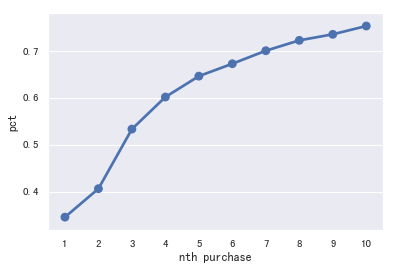

In [215]:
sns.pointplot(data = nth_purchase_pct, x = 'nth purchase',  y='pct')
#全部註冊人數中只有30.4%會購物
#購物第一次的人中，只有40%會繼續買第二次
#但購物三次之後，會繼續買的比例越來越高

In [288]:
temp = fre_all[fre_all['count'] <= 10]['count'].value_counts().to_frame().reset_index()
temp.columns = ['nth purchase', 'count']
T = pd.merge(nth_purchase_pct, temp, on='nth purchase', how='left' )
#T.to_csv('draw1.csv', sep=',', index=False)
T['loss'] = 1 - T['pct']


In [289]:
T

,nth purchase,pct,count,loss
0,1,0.345513,292091,0.654487
1,2,0.406115,93274,0.593885
2,3,0.533023,42446,0.466977
3,4,0.601319,22677,0.398681
4,5,0.645783,13551,0.354217
5,6,0.672230,8339,0.327770
6,7,0.699950,5408,0.300050
7,8,0.721997,3724,0.278003
8,9,0.734852,2554,0.265148
9,10,0.752543,1740,0.247457


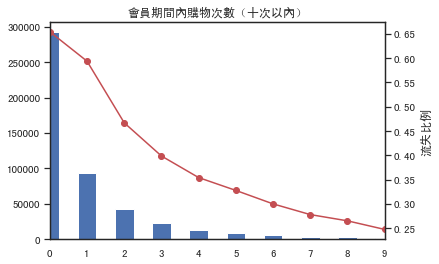

In [290]:
T['count'].plot(x='nth purchase',kind="bar")
ax = T['loss'].plot(secondary_y=True, color='r', marker='o')
ax.set_ylabel('流失比例')
ax.set_xlabel('購物次數')
ax.set_title('會員期間內購物次數（十次以內）')

plt.show()


In [25]:
fre_all['label'].value_counts()

C    143723
D    121995
E     93811
B     87094
F     30256
A     14952
Name: label, dtype: int64

In [26]:
print(fre_all['count'].describe())
np.quantile(fre_all['count'], 0.95)

count    491831.000000
mean          2.067875
std           2.294215
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          97.000000
Name: count, dtype: float64


6.0

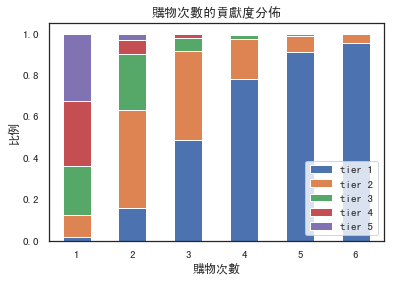

In [324]:
sns.set_style('white',{"font.sans-serif":['simhei', 'Arial']})


c1 = fre_all[fre_all['count'] == 1]['ctrbn'].value_counts().to_frame()
c2 = fre_all[fre_all['count'] == 2]['ctrbn'].value_counts().to_frame()
c3 = fre_all[fre_all['count'] == 3]['ctrbn'].value_counts().to_frame()
c4 = fre_all[fre_all['count'] == 4]['ctrbn'].value_counts().to_frame()
c5 = fre_all[fre_all['count'] == 5]['ctrbn'].value_counts().to_frame()
c6 = fre_all[fre_all['count'] == 6]['ctrbn'].value_counts().to_frame()
C = pd.concat([c1, c2, c3, c4, c5, c6], axis=1)
C.columns = [1,2,3,4,5,6]
#get percentage
C[1] = C[1] / C.sum()[1]
C[2] = C[2] / C.sum()[2]
C[3] = C[3] / C.sum()[3]
C[4] = C[4] / C.sum()[4]
C[5] = C[5] / C.sum()[5]
C[6] = C[6] / C.sum()[6]
C


C.transpose().plot(kind='bar', stacked=True)
plt.title('購物次數的貢獻度分佈', fontsize=13)
plt.xlabel('購物次數', fontsize=12)
plt.ylabel('比例', fontsize=12)
plt.xticks(rotation='horizontal')
plt.show()

#stack.plot(kind='bar', stacked=True)

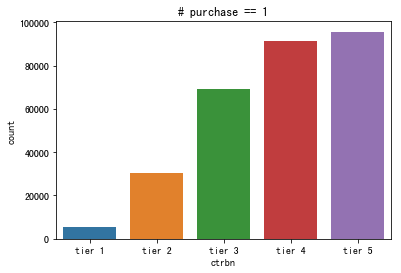

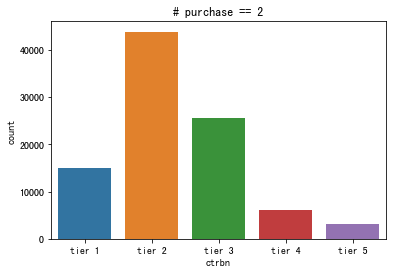

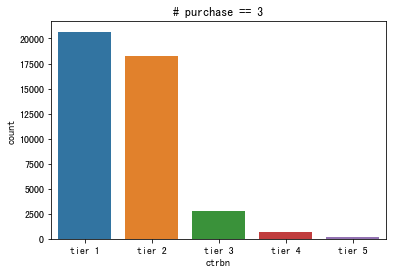

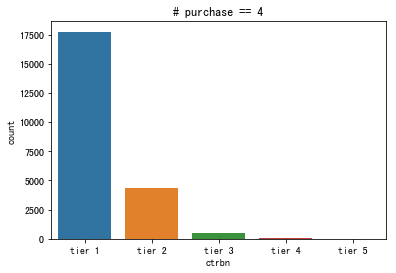

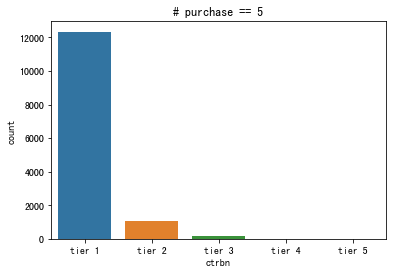

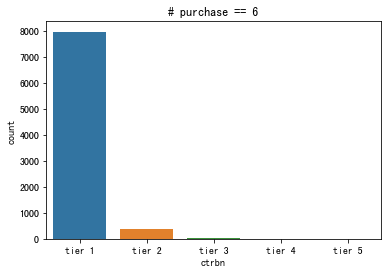

In [27]:
for i in range(1,7):
    sns.countplot(data = fre_all[fre_all['count'] == i], x = 'ctrbn', order = ['tier 1', 'tier 2', 'tier 3', 'tier 4', 'tier 5'])
    plt.title('# purchase == %i' %i)
    plt.show()
#基本上如果購買三次以上，帶來的貢獻就已很高    

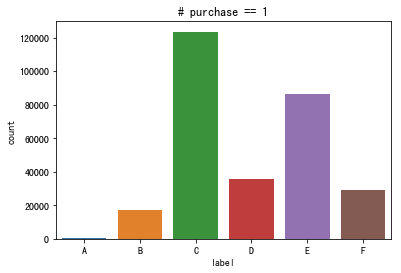

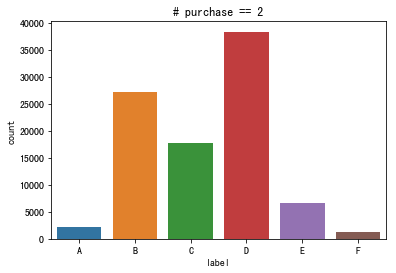

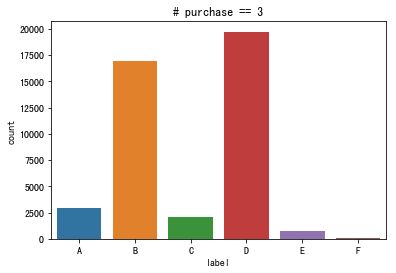

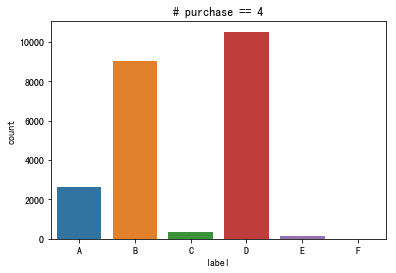

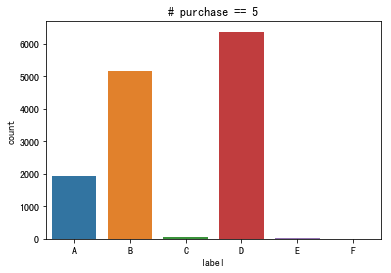

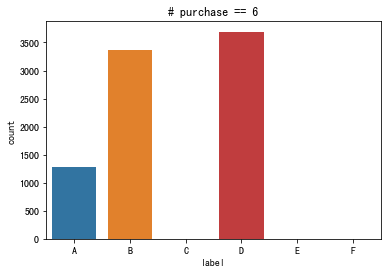

In [28]:
for i in range(1,7):
    sns.countplot(data = fre_all[fre_all['count'] == i], x = 'label', order = ['A', 'B', 'C', 'D', 'E', 'F'])
    plt.title('# purchase == %i' %i)
    plt.show()
#基本上如果購買兩次以上，帶來的貢獻就已很高    

### data cleaning

In [29]:
#處理商品分類
repeats = df_orders['Quantity'].values
df_temp = pd.DataFrame(np.repeat(df_orders.values, repeats, axis=0))
df_temp.columns = df_orders.columns
print(df_temp.shape)

#商品分類
up25= np.quantile(df_temp['UnitPrice'],0.25)
up50= np.quantile(df_temp['UnitPrice'],0.50)
up75= np.quantile(df_temp['UnitPrice'],0.75)
up90= np.quantile(df_temp['UnitPrice'],0.90)
up100= np.quantile(df_temp['UnitPrice'],1)

bins = [0,up25,up50,up75,up90,up100] #按照分佈來切
df_temp['cut_UnitPrice'] = pd.cut(df_temp['UnitPrice'], bins = bins)

df_temp = pd.get_dummies(df_temp, columns = ['cut_UnitPrice'], prefix = ['cut_UnitPrice'])

#同個會員的資料合併 #購物車編號是unique的
cut_names = df_temp.columns.tolist()[:-6:-1]
groupby_item = df_temp.groupby(['MemberId','OrderGroupCode'])[cut_names].sum()
groupby_item.head()

(4170439, 29)


cut_UnitPrice_(399.0, 3500.0]  \
MemberId OrderGroupCode                                                                      
1362     b'\xffNo\xc3\xdb\x84\r-g\xe6\x15eL\x85\xd6\x94m...                              0   
1384     b'\x11v\xabF\xee\xf7\x1foK\xae\xf8\xf6C\xb5\xf9...                              1   
         b'\x83\xc9\xb0\r\xdd\xa0\x1d\x19\xad\x88\x00\x1...                              0   
         b'l\xf4\xde|\xb8\xa7\xd7z\x8f\x9c\xd3\x07\x8f\x...                              1   
1391     b'(Qby\xf7\xe7\xcei\xda\xdc\x07D\x10p\xa4"\x14G...                              1   

                                                             cut_UnitPrice_(311.0, 399.0]  \
MemberId OrderGroupCode                                                                     
1362     b'\xffNo\xc3\xdb\x84\r-g\xe6\x15eL\x85\xd6\x94m...                             0   
1384     b'\x11v\xabF\xee\xf7\x1foK\xae\xf8\xf6C\xb5\xf9...                             0   
         b'\x83\xc9\xb0\r\xdd\xa0\x1d\x19\xad\x88\x00\x1...                             0   
         b'l\xf4\xde|\xb8\xa7\xd7z\x8f\x9c\xd3\x07\x8f\x...                             1   
1391     b'(Qby\xf7\xe7\xcei\xda\xdc\x07D\x10p\xa4"\x14G...                             0   

                                                             cut_UnitPrice_(235.0, 311.0]  \
MemberId OrderGroupCode                                                                     
1362     b'\xffNo\xc3\xdb\x84\r-g\xe6\x15eL\x85\xd6\x94m...                             1   
1384     b'\x11v\xabF\xee\xf7\x1foK\xae\xf8\xf6C\xb5\xf9...                             0   
         b'\x83\xc9\xb0\r\xdd\xa0\x1d\x19\xad\x88\x00\x1...                             1   
         b'l\xf4\xde|\xb8\xa7\xd7z\x8f\x9c\xd3\x07\x8f\x...                             0   
1391     b'(Qby\xf7\xe7\xcei\xda\xdc\x07D\x10p\xa4"\x14G...                             0   

                                                             cut_UnitPrice_(199.0, 235.0]  \
MemberId OrderGroupCode                                                                     
1362     b'\xffNo\xc3\xdb\x84\r-g\xe6\x15eL\x85\xd6\x94m...                             0   
1384     b'\x11v\xabF\xee\xf7\x1foK\xae\xf8\xf6C\xb5\xf9...                             0   
         b'\x83\xc9\xb0\r\xdd\xa0\x1d\x19\xad\x88\x00\x1...                             0   
         b'l\xf4\xde|\xb8\xa7\xd7z\x8f\x9c\xd3\x07\x8f\x...                             0   
1391     b'(Qby\xf7\xe7\xcei\xda\xdc\x07D\x10p\xa4"\x14G...                             0   

                                                             cut_UnitPrice_(0.0, 199.0]  
MemberId OrderGroupCode                                                                  
1362     b'\xffNo\xc3\xdb\x84\r-g\xe6\x15eL\x85\xd6\x94m...                           3  
1384     b'\x11v\xabF\xee\xf7\x1foK\xae\xf8\xf6C\xb5\xf9...                           0  
         b'\x83\xc9\xb0\r\xdd\xa0\x1d\x19\xad\x88\x00\x1...                           2  
         b'l\xf4\xde|\xb8\xa7\xd7z\x8f\x9c\xd3\x07\x8f\x...                           0  
1391     b'(Qby\xf7\xe7\xcei\xda\xdc\x07D\x10p\xa4"\x14G...                           2

In [30]:
#購買時間拆成day of week和hour of day
df_orders['SalesOrderSlaveDateTime'] = pd.to_datetime(df_orders['SalesOrderSlaveDateTime'])
df_orders['hour'] = df_orders['SalesOrderSlaveDateTime'].dt.hour
df_orders['hour'] = df_orders['hour'] + 1
df_orders['dayow'] = df_orders['SalesOrderSlaveDateTime'].dt.weekday
df_orders['dayow'] = df_orders['dayow']+ 1
df_orders['month'] = df_orders['SalesOrderSlaveDateTime'].dt.month

In [31]:
pq = ['Quantity','SalesOrderSlaveTotalPayment', 'ECouponDiscount', 'PromotionDiscount']
want = ['DateId','MemberId','OrderGroupCode','TrackSourceTypeDef','TrackDeviceTypeDef','PayProfileTypeDef','City','DeliverTypeDef','hour','dayow','month']
df_tidy = df_orders.groupby(want, as_index=False)[pq].sum()
df_tidy

,DateId,MemberId,OrderGroupCode,TrackSourceTypeDef,TrackDeviceTypeDef,PayProfileTypeDef,City,DeliverTypeDef,hour,dayow,month,Quantity,SalesOrderSlaveTotalPayment,ECouponDiscount,PromotionDiscount
0,2015-05-06,192540,"b""\xcbd\x1c\x06\x9d\xd1\x19\xfc_'`\x8b\xaf\xcf...",AndroidApp,Mobile,Family,彰化縣,Family,23,3,5,6,1357.0,0.0,0.0
1,2015-05-06,205786,b'\xcc\xb55c\xf2k\xd3U\xce\xf6\xec:\xf7\x90\xe...,iOSApp,Mobile,Family,新北市,Family,21,3,5,5,1033.0,0.0,0.0
2,2015-05-06,297791,b'\xcb\xea\xe3{\xec\xea{>\x86]\xa4A:c\xeem\x93...,AndroidApp,Mobile,Family,新北市,Family,21,3,5,1,299.0,0.0,0.0
3,2015-05-06,403195,b'\x8dM\x91\xa9\xbd^#\xbe2U\x12\xdd\x8f\x8e\xf...,iOSApp,Mobile,SevenEleven,新北市,SevenEleven,24,3,5,1,299.0,0.0,0.0
4,2015-05-06,808449,b'M\xbb\x18\x18\xa5\xcf.\x97\xd7\x99\xadKM\x17...,AndroidApp,Mobile,SevenEleven,苗栗縣,SevenEleven,23,3,5,6,1194.0,0.0,0.0
5,2015-05-07,80753,b'{\xde\x10\x01\xbf\x1c)\xaa/;c\x17wY\xe3\x04{...,iOSApp,Mobile,Family,台北市,Family,21,4,5,1,253.0,0.0,0.0
6,2015-05-07,89776,b'\xcd\x1d\xe6\xf1\xb8h\x1b\xd1V\x16\xf4\xc2\x...,iOSApp,Mobile,SevenEleven,台北市,SevenEleven,9,4,5,2,398.0,0.0,0.0
7,2015-05-07,239980,b'\xe6?\x0f\x1e!\xd3;\x84|\xa4\x10\x7f\xed\x03...,AndroidApp,Mobile,Family,桃園市,Family,1,4,5,5,1016.0,0.0,0.0
8,2015-05-07,357146,b'R@\x10\xb2\x1f\xda$#n*!38\xdc\xcejT\xbe\x95\...,iOSApp,Mobile,Family,台北市,Family,12,4,5,4,819.0,0.0,0.0
9,2015-05-07,658726,"b""\xaey\x05\xc2'P\x17QI\x9dQ\\\x08\xe6=\xa8s\x...",AndroidApp,Mobile,Family,屏東縣,Family,17,4,5,1,199.0,0.0,0.0


In [32]:
#根據有沒有領開卡禮設boolean
df_members.loc[df_members.OpenCardPresent == 0, 'get_OpenCardPresent'] = False
df_members.loc[df_members.OpenCardPresent != 0, 'get_OpenCardPresent'] = True
#根據有沒有領生日禮設boolean
df_members.loc[df_members.LastBirthdayPresentYear == 0, 'get_LastBirthdayPresentYear'] = False
df_members.loc[df_members.LastBirthdayPresentYear != 0, 'get_LastBirthdayPresentYear'] = True

#把有沒有生日禮和開卡禮的狀態，merge到df_tidy
df_tidy = pd.merge(df_tidy, df_members[['MemberId', 'get_OpenCardPresent','get_LastBirthdayPresentYear']], on = 'MemberId', how='left')

#開卡里跟生日禮是null的改成false
indices= df_tidy['get_OpenCardPresent'].isnull()
df_tidy.loc[indices,'get_OpenCardPresent'] = df_tidy.loc[indices,'get_OpenCardPresent'].fillna(False)
indices= df_tidy['get_LastBirthdayPresentYear'].isnull()
df_tidy.loc[indices,'get_LastBirthdayPresentYear'] = df_tidy.loc[indices,'get_LastBirthdayPresentYear'].fillna(False)

In [33]:
#數值型資料轉成類別資料

#縣市:以地區來分
north = ['台北市','新北市', '桃園市', '新竹市','苗栗縣','新竹縣', '基隆市']
south = ['高雄市','台南市','屏東縣','嘉義縣','嘉義市','屏東市']
mid = ['台中市','彰化縣','南投縣','雲林縣' ]
east = ['宜蘭縣','花蓮縣','台東縣','澎湖縣','台東市']

df_tidy = df_tidy.assign(location_North = np.where(df_tidy['City'].isin(north), 1, 0))
df_tidy = df_tidy.assign(location_South = np.where(df_tidy['City'].isin(south), 1, 0))
df_tidy = df_tidy.assign(location_Mid = np.where(df_tidy['City'].isin(mid), 1, 0))
df_tidy = df_tidy.assign(location_East = np.where(df_tidy['City'].isin(east), 1, 0))

#weekday
weekday = [1,2,3,4,5]
weekend = [6,7]

df_tidy = df_tidy.assign(Weekend = np.where(df_tidy['dayow'].isin(weekend), 1, 0)) #weekend=1, weekday=0

#time of day
midnight = [2,3,4,5,6,7]
morning = [8,9,10,11,12]
afternoon = [13,14,15,16,17]
night = [18,19,20,21,22,23,24,1]

df_tidy = df_tidy.assign(time_Midnight = np.where(df_tidy['hour'].isin(midnight), 1, 0))
df_tidy = df_tidy.assign(time_Morning = np.where(df_tidy['hour'].isin(morning), 1, 0))
df_tidy = df_tidy.assign(time_Afternoon = np.where(df_tidy['hour'].isin(afternoon), 1, 0))
df_tidy = df_tidy.assign(time_Night = np.where(df_tidy['hour'].isin(night), 1, 0))

#season
spring = [3,4,5]
summer = [6,7,8]
fall = [9,10,11]
winter = [12,1,2]

df_tidy = df_tidy.assign(season_spring = np.where(df_tidy['month'].isin(spring), 1, 0))
df_tidy = df_tidy.assign(season_summer = np.where(df_tidy['month'].isin(summer), 1, 0))
df_tidy = df_tidy.assign(season_fall = np.where(df_tidy['month'].isin(fall), 1, 0))
df_tidy = df_tidy.assign(season_winter = np.where(df_tidy['month'].isin(winter), 1, 0))


#有沒有使用ecoupon或促銷
df_tidy['ECouponDiscount'] = (df_tidy['ECouponDiscount'] != 0)
df_tidy['PromotionDiscount'] = (df_tidy['PromotionDiscount'] != 0)


In [34]:
#one hot encoding
get_dummy = ['TrackSourceTypeDef','TrackDeviceTypeDef','PayProfileTypeDef','DeliverTypeDef']
df_tidy = pd.get_dummies(df_tidy, columns = get_dummy , prefix = get_dummy)

df_tidy.drop(['City','hour','dayow','month'],axis=1, inplace=True)

In [35]:
#加上商品類別
df_tidy = pd.merge(df_tidy,groupby_item, on = 'OrderGroupCode', how='left')

In [36]:
df_tidy

,DateId,MemberId,OrderGroupCode,Quantity,SalesOrderSlaveTotalPayment,ECouponDiscount,PromotionDiscount,get_OpenCardPresent,get_LastBirthdayPresentYear,location_North,location_South,location_Mid,location_East,Weekend,time_Midnight,time_Morning,time_Afternoon,time_Night,season_spring,season_summer,season_fall,season_winter,TrackSourceTypeDef_AndroidApp,TrackSourceTypeDef_Web,TrackSourceTypeDef_iOSApp,TrackDeviceTypeDef_Mobile,TrackDeviceTypeDef_PC,TrackDeviceTypeDef_Pad,PayProfileTypeDef_ATM,PayProfileTypeDef_CreditCardOnce,PayProfileTypeDef_Family,PayProfileTypeDef_LinePay,PayProfileTypeDef_SevenEleven,DeliverTypeDef_Family,DeliverTypeDef_Home,DeliverTypeDef_SevenEleven,"cut_UnitPrice_(399.0, 3500.0]","cut_UnitPrice_(311.0, 399.0]","cut_UnitPrice_(235.0, 311.0]","cut_UnitPrice_(199.0, 235.0]","cut_UnitPrice_(0.0, 199.0]"
0,2015-05-06,192540,"b""\xcbd\x1c\x06\x9d\xd1\x19\xfc_'`\x8b\xaf\xcf...",6,1357.0,False,False,False,False,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,4
1,2015-05-06,205786,b'\xcc\xb55c\xf2k\xd3U\xce\xf6\xec:\xf7\x90\xe...,5,1033.0,False,False,False,False,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,4
2,2015-05-06,297791,b'\xcb\xea\xe3{\xec\xea{>\x86]\xa4A:c\xeem\x93...,1,299.0,False,False,False,False,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
3,2015-05-06,403195,b'\x8dM\x91\xa9\xbd^#\xbe2U\x12\xdd\x8f\x8e\xf...,1,299.0,False,False,False,False,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
4,2015-05-06,808449,b'M\xbb\x18\x18\xa5\xcf.\x97\xd7\x99\xadKM\x17...,6,1194.0,False,False,False,False,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,6
5,2015-05-07,80753,b'{\xde\x10\x01\xbf\x1c)\xaa/;c\x17wY\xe3\x04{...,1,253.0,False,False,False,False,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
6,2015-05-07,89776,b'\xcd\x1d\xe6\xf1\xb8h\x1b\xd1V\x16\xf4\xc2\x...,2,398.0,False,False,False,False,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,2
7,2015-05-07,239980,b'\xe6?\x0f\x1e!\xd3;\x84|\xa4\x10\x7f\xed\x03...,5,1016.0,False,False,False,False,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,4
8,2015-05-07,357146,b'R@\x10\xb2\x1f\xda$#n*!38\xdc\xcejT\xbe\x95\...,4,819.0,False,False,True,True,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,3
9,2015-05-07,658726,"b""\xaey\x05\xc2'P\x17QI\x9dQ\\\x08\xe6=\xa8s\x...",1,199.0,False,False,False,False,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1


In [37]:
npurchase_list = df_tidy.groupby('MemberId', as_index=False)['OrderGroupCode'].count()
npurchase_list.columns = ['MemberId','count']
df_tidy = pd.merge(df_tidy,npurchase_list, on = 'MemberId', how='left')

In [38]:
df_1st = df_tidy.groupby('MemberId').head(1)

temp = df_orders.groupby(['DateId','MemberId', 'OrderGroupCode'], as_index = False)['mean_payment'].mean().groupby('MemberId').head(1)
df_1st = pd.merge(df_1st, temp[['MemberId','mean_payment']], on = 'MemberId', how='left')

df_1st['retain'] = (df_1st['count'] >=2)
drop_list =['DateId', 'OrderGroupCode']
df_1st = df_1st.drop(drop_list ,axis=1)

In [39]:
#到這邊先存檔
df_1st.to_csv('df_1st.csv', sep=',', index=False)

In [40]:
os.getcwd()

'/Users/yichingchan/Documents/91APP'

In [41]:
df_2nd = df_tidy[df_tidy['count'] >= 2].groupby('MemberId').head(2)
fre = df_2nd.groupby('MemberId')['DateId'].apply(list).reset_index()
fre['frequency'] = fre.apply(f, axis=1)
fre['fre_mean'] = fre.apply(mean, axis=1)

In [43]:
id_lst = list(npurchase_list[npurchase_list['count'] >=2]['MemberId'])
valid_orders = df_orders[df_orders['MemberId'].isin(id_lst)].sort_values(by='DateId')

temp = valid_orders.groupby(['DateId','MemberId', 'OrderGroupCode'], as_index = False)['mean_payment'].mean()
temp2 = temp.groupby('MemberId').head(2).groupby('MemberId')['mean_payment'].mean()
df_2nd = pd.merge(df_2nd, temp2, on = 'MemberId', how='left')

In [44]:
df_2nd['retain'] = (df_2nd['count'] >=3)

In [45]:
#到這邊先存檔
df_2nd.to_csv('df_2nd.csv', sep=',', index=False)

In [336]:
df_3rd = df_tidy[df_tidy['count'] >= 3].groupby('MemberId').head(3)
fre = df_3rd.groupby('MemberId')['DateId'].apply(list).reset_index()
fre['frequency'] = fre.apply(f, axis=1)
fre['fre_mean'] = fre.apply(mean, axis=1)

id_lst = list(npurchase_list[npurchase_list['count'] >=3]['MemberId'])
valid_orders = df_orders[df_orders['MemberId'].isin(id_lst)].sort_values(by='DateId')

temp = valid_orders.groupby(['DateId','MemberId', 'OrderGroupCode'], as_index = False)['mean_payment'].mean()
temp2 = temp.groupby('MemberId').head(3).groupby('MemberId')['mean_payment'].mean()
df_3rd = pd.merge(df_3rd, temp2, on = 'MemberId', how='left')


df_3rd['retain'] = (df_3rd['count'] >=4)
df_3rd = df_3rd.drop(['DateId', 'OrderGroupCode'], axis=1)

In [341]:
df_3rd = pd.merge(df_3rd, fre[['MemberId', 'fre_mean']], on = 'MemberId', how='left')
df_3rd.head()

,MemberId,Quantity,SalesOrderSlaveTotalPayment,ECouponDiscount,PromotionDiscount,get_OpenCardPresent,get_LastBirthdayPresentYear,location_North,location_South,location_Mid,location_East,Weekend,time_Midnight,time_Morning,time_Afternoon,time_Night,season_spring,season_summer,season_fall,season_winter,TrackSourceTypeDef_AndroidApp,TrackSourceTypeDef_Web,TrackSourceTypeDef_iOSApp,TrackDeviceTypeDef_Mobile,TrackDeviceTypeDef_PC,TrackDeviceTypeDef_Pad,PayProfileTypeDef_ATM,PayProfileTypeDef_CreditCardOnce,PayProfileTypeDef_Family,PayProfileTypeDef_LinePay,PayProfileTypeDef_SevenEleven,DeliverTypeDef_Family,DeliverTypeDef_Home,DeliverTypeDef_SevenEleven,"cut_UnitPrice_(399.0, 3500.0]","cut_UnitPrice_(311.0, 399.0]","cut_UnitPrice_(235.0, 311.0]","cut_UnitPrice_(199.0, 235.0]","cut_UnitPrice_(0.0, 199.0]",count,mean_payment,retain,fre_mean
0,192540,6,1357.0,False,False,False,False,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,4,5,227.944444,True,215.0
1,80753,1,253.0,False,False,False,False,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,3,204.500000,False,77.5
2,239980,5,1016.0,False,False,False,False,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,4,3,233.733333,False,60.5
3,658726,1,199.0,False,False,False,False,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,6,201.000000,True,0.0
4,658726,1,263.0,False,False,False,False,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,6,201.000000,True,0.0


In [342]:
#到這邊先存檔
df_3rd.to_csv('df_3rd.csv', sep=',', index=False)

##  預測第二年留存

In [46]:
df_period1 = df_orders[(df_orders['DateId'] >= '2016-05-01') & (df_orders['DateId'] <= '2017-04-30')]
df_period2 = df_orders[(df_orders['DateId'] >= '2017-05-01') & (df_orders['DateId'] <= '2018-04-15')]

In [47]:
period1_count = df_period1.groupby(['MemberId', 'OrderGroupCode'], as_index=False)['Quantity'].sum().groupby('MemberId', as_index=False)['OrderGroupCode'].count()
period1_count.columns = ['MemberId', 'count']

In [48]:
df = df_tidy[(df_tidy['DateId'] >= '2016-05-01') & (df_tidy['DateId'] <= '2017-04-30')]
df = df.drop('count', axis=1)
df = pd.merge(df, period1_count, on='MemberId', how='left')

In [69]:
df

,DateId,MemberId,OrderGroupCode,Quantity,SalesOrderSlaveTotalPayment,ECouponDiscount,PromotionDiscount,get_OpenCardPresent,get_LastBirthdayPresentYear,location_North,location_South,location_Mid,location_East,Weekend,time_Midnight,time_Morning,time_Afternoon,time_Night,season_spring,season_summer,season_fall,season_winter,TrackSourceTypeDef_AndroidApp,TrackSourceTypeDef_Web,TrackSourceTypeDef_iOSApp,TrackDeviceTypeDef_Mobile,TrackDeviceTypeDef_PC,TrackDeviceTypeDef_Pad,PayProfileTypeDef_ATM,PayProfileTypeDef_CreditCardOnce,PayProfileTypeDef_Family,PayProfileTypeDef_LinePay,PayProfileTypeDef_SevenEleven,DeliverTypeDef_Family,DeliverTypeDef_Home,DeliverTypeDef_SevenEleven,"cut_UnitPrice_(399.0, 3500.0]","cut_UnitPrice_(311.0, 399.0]","cut_UnitPrice_(235.0, 311.0]","cut_UnitPrice_(199.0, 235.0]","cut_UnitPrice_(0.0, 199.0]",count
0,2016-05-01,3214,b'\xef\xed\x92\xac;\x8d\xf3\xfc\x17\x0e\xe2g\x...,10,1784.0,False,True,False,False,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,9,5
1,2016-05-01,13109,b'4E\xcasb\xe7\xceS\xb1 \xd7\x1dL)\x80>\x02c\\...,7,2195.0,False,True,False,False,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,4,2,0,1,2
2,2016-05-01,19973,"b',\tx\xad\xcb\xf4\x8d\xbb\xcc\xed\xb0s\xd30\x...",6,1006.0,True,True,True,True,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,5,1
3,2016-05-01,27774,b'\xab\x0f\xa9\x9e7\x07\x80\xe6r\xa7\xf3%\xec\...,5,895.0,True,False,False,False,0,0,0,1,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,4,1
4,2016-05-01,27875,"b'\xa8-+~""?]Q\xd9\xcb9>\xf2\xa2`\xbb\xdfuh\xac'",6,1325.0,True,False,True,True,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,5,2
5,2016-05-01,33867,"b""#\xfe\xf6\xad\x91\x90A)\x84pU\xb6w|<e\xd7l\x...",4,766.0,False,False,True,True,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,4,16
6,2016-05-01,43567,b'\xb7L\x1d\xa6\xae\xed\xc5\x98\x86b\x04\xbb\x...,3,547.0,True,False,True,True,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,3,5
7,2016-05-01,45501,b'\xaf+\x14\xfbI\x94.\xcd\x9a;\xe0\x87\x88\x10...,5,997.0,True,True,True,True,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,4,3
8,2016-05-01,52043,b'\xe8\x07 \xd1\xa7{\x17\xaePB\x0f\xf3\x8e=\r\...,8,1573.0,True,False,True,True,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,7,5
9,2016-05-01,57287,"b'8O\x89v|\x88\xf3\x138\xae,\xdb\xdf\xab\xd9s\...",6,1246.0,False,True,False,False,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,2,0,4,6


In [49]:
period1_fre = df.groupby('MemberId')['DateId'].apply(list).reset_index()
period1_fre['frequency'] = period1_fre.apply(f, axis=1)
period1_fre['fre_mean'] = period1_fre.apply(mean, axis=1)
#只購買一次的補植365
period1_fre['fre_mean'] = period1_fre['fre_mean'].fillna(365)

In [80]:
df_period1.head()

,DateId,MemberId,OrderGroupCode,TrackSourceTypeDef,TrackDeviceTypeDef,PayProfileTypeDef,SalesOrderSlaveId,SalePageId,IsMajor,IsGift,IsSalePageGift,Quantity,UnitPrice,PromotionDiscount,ECouponId,ECouponDiscount,SalesOrderSlaveTotalPayment,SalesOrderSlaveDateTime,SalesOrderReceiverId,City,District,ZipCode,StoreName,StoreId,DeliverTypeDef,StatusDef,ReturnGoodsDateId,CauseDef,mean_payment,hour,dayow,month
81877,2017-03-29,975582,b'y\x84\xe7\x07\x8f \xda\xa10\x8ez\xf3\xc2\x86...,iOSApp,Mobile,Family,31990560,3008088,True,False,False,1,199.0,-12.0,0,0.0,187.0,2017-03-29 15:10:56.763,10990875,花蓮縣,花蓮市,970.0,全家花蓮國盛店,5304,Family,Finish,NaN,NaN,187.0,16,3,3
81878,2017-03-29,975582,b'y\x84\xe7\x07\x8f \xda\xa10\x8ez\xf3\xc2\x86...,iOSApp,Mobile,Family,31990561,2012251,True,False,False,1,199.0,-12.0,0,0.0,187.0,2017-03-29 15:10:56.793,10990875,花蓮縣,花蓮市,970.0,全家花蓮國盛店,5304,Family,Finish,NaN,NaN,187.0,16,3,3
81879,2017-03-29,975582,b'y\x84\xe7\x07\x8f \xda\xa10\x8ez\xf3\xc2\x86...,iOSApp,Mobile,Family,31990562,3026768,True,False,False,1,199.0,-12.0,0,0.0,187.0,2017-03-29 15:10:56.810,10990875,花蓮縣,花蓮市,970.0,全家花蓮國盛店,5304,Family,Finish,NaN,NaN,187.0,16,3,3
81880,2017-03-29,975582,b'y\x84\xe7\x07\x8f \xda\xa10\x8ez\xf3\xc2\x86...,iOSApp,Mobile,Family,31990563,2255182,True,False,False,1,199.0,-81.0,0,0.0,118.0,2017-03-29 15:10:56.827,10990875,花蓮縣,花蓮市,970.0,全家花蓮國盛店,5304,Family,Finish,NaN,NaN,118.0,16,3,3
81881,2017-03-29,975582,b'y\x84\xe7\x07\x8f \xda\xa10\x8ez\xf3\xc2\x86...,iOSApp,Mobile,Family,31990564,2986667,True,False,False,1,199.0,-81.0,0,0.0,118.0,2017-03-29 15:10:56.840,10990875,花蓮縣,花蓮市,970.0,全家花蓮國盛店,5304,Family,Finish,NaN,NaN,118.0,16,3,3


In [81]:
#第一年消費Ｎ筆以上
def get_transaction_more_than_i(i):
    
    get = ['MemberId','Quantity', 'SalesOrderSlaveTotalPayment', 'cut_UnitPrice_(399.0, 3500.0]', 'cut_UnitPrice_(311.0, 399.0]',
       'cut_UnitPrice_(235.0, 311.0]', 'cut_UnitPrice_(199.0, 235.0]','cut_UnitPrice_(0.0, 199.0]']
    i_above = df[df['count'] >= i].groupby('MemberId', as_index=False).sum()[get]
    
    idvalid = list(df[df['count'] >= i]['MemberId'])

    group = df_period1[df_period1['MemberId'].isin(idvalid)].groupby(['MemberId', 'OrderGroupCode'], as_index = False)['mean_payment'].mean()
    meanPay = group.groupby('MemberId', as_index=False)['mean_payment'].mean()
    
    get = ['MemberId','ECouponDiscount', 'PromotionDiscount',
       'get_OpenCardPresent', 'get_LastBirthdayPresentYear', 'location_North',
       'location_South', 'location_Mid', 'location_East', 'Weekend',
       'time_Midnight', 'time_Morning', 'time_Afternoon', 'time_Night',
       'season_spring', 'season_summer', 'season_fall', 'season_winter',
       'TrackSourceTypeDef_AndroidApp', 'TrackSourceTypeDef_Web',
       'TrackSourceTypeDef_iOSApp', 'TrackDeviceTypeDef_Mobile',
       'TrackDeviceTypeDef_PC', 'TrackDeviceTypeDef_Pad',
       'PayProfileTypeDef_ATM', 'PayProfileTypeDef_CreditCardOnce',
       'PayProfileTypeDef_Family', 'PayProfileTypeDef_LinePay',
       'PayProfileTypeDef_SevenEleven', 'DeliverTypeDef_Family',
       'DeliverTypeDef_Home', 'DeliverTypeDef_SevenEleven', 'count']
    last_row = df.sort_values(by='DateId').groupby('MemberId', as_index=False).tail(1)[get]

    i_above = pd.merge(i_above, last_row, on='MemberId', how='left' )
    i_above = pd.merge(i_above, period1_fre[['MemberId', 'fre_mean']], on='MemberId', how='left' )
    i_above = pd.merge(i_above, meanPay, on='MemberId', how='left' )
    
    return i_above

In [74]:
q_rank = df_period2.groupby('MemberId', as_index=False)['Quantity','SalesOrderSlaveTotalPayment'].sum()
p_rank = df_period2.groupby('MemberId', as_index=False)['mean_payment'].mean()
qp = pd.merge(q_rank, p_rank, on='MemberId', how='left')

q25 = np.quantile(qp['Quantity'],0.25)
q50= np.quantile(qp['Quantity'],0.5)
q75 = np.quantile(qp['Quantity'],0.75)

p25 = np.quantile(qp['mean_payment'],0.25)
p50= np.quantile(qp['mean_payment'],0.5)
p75 = np.quantile(qp['mean_payment'],0.75)
    
c20 = np.quantile(qp['SalesOrderSlaveTotalPayment'],0.2)
c40= np.quantile(qp['SalesOrderSlaveTotalPayment'],0.4)
c60 = np.quantile(qp['SalesOrderSlaveTotalPayment'],0.6)
c80 = np.quantile(qp['SalesOrderSlaveTotalPayment'],0.8)

qp['label'] = qp.apply(label, axis=1)
qp['ctrbn'] = qp.apply(ctrbn, axis=1)


In [82]:
one_above = get_transaction_more_than_i(1)
one_above = pd.merge(one_above, qp[['MemberId', 'label', 'ctrbn']], on='MemberId', how='left')
one_above = one_above.fillna('Loss')
one_above['retain'] = one_above['label'] != 'Loss'
print(one_above['retain'].value_counts())
print(one_above['label'].value_counts())
print(one_above['ctrbn'].value_counts())

False    184348
True      72142
Name: retain, dtype: int64
Loss    184348
D        20176
C        18660
B        14827
E        11166
A         3678
F         3635
Name: label, dtype: int64
Loss      184348
tier 1     22369
tier 2     15805
tier 3     13447
tier 4     10580
tier 5      9941
Name: ctrbn, dtype: int64


In [84]:
twice_above  = get_transaction_more_than_i(2)
twice_above = pd.merge(twice_above, qp[['MemberId', 'label', 'ctrbn']], on='MemberId', how='left')
twice_above = twice_above.fillna('Loss')
twice_above['retain'] = twice_above['label'] != 'Loss'
print(twice_above['retain'].value_counts())
print(twice_above['label'].value_counts())
print(twice_above['ctrbn'].value_counts())

False    47381
True     37720
Name: retain, dtype: int64
Loss    47381
D       11389
B        8909
C        8477
E        4965
A        2508
F        1472
Name: label, dtype: int64
Loss      47381
tier 1    14604
tier 2     8068
tier 3     6288
tier 4     4664
tier 5     4096
Name: ctrbn, dtype: int64


In [85]:
three_above  = get_transaction_more_than_i(3)
three_above = pd.merge(three_above, qp[['MemberId', 'label', 'ctrbn']], on='MemberId', how='left')
three_above = three_above.fillna('Loss')
three_above['retain'] = three_above['label'] != 'Loss'
print(three_above['retain'].value_counts())
print(three_above['label'].value_counts())
print(three_above['ctrbn'].value_counts())

True     21272
False    16860
Name: retain, dtype: int64
Loss    16860
D        6656
B        5663
C        4240
E        2367
A        1700
F         646
Name: label, dtype: int64
Loss      16860
tier 1     9686
tier 2     4350
tier 3     3175
tier 4     2193
tier 5     1868
Name: ctrbn, dtype: int64


In [86]:
four_above  = get_transaction_more_than_i(4)
four_above = pd.merge(four_above, qp[['MemberId', 'label', 'ctrbn']], on='MemberId', how='left')
four_above = four_above.fillna('Loss')
four_above['retain'] = four_above['label'] != 'Loss'
print(four_above['retain'].value_counts())
print(four_above['label'].value_counts())
print(four_above['ctrbn'].value_counts())

True     12650
False     7156
Name: retain, dtype: int64
Loss    7156
D       4072
B       3719
C       2174
A       1189
E       1177
F        319
Name: label, dtype: int64
Loss      7156
tier 1    6536
tier 2    2458
tier 3    1677
tier 4    1049
tier 5     930
Name: ctrbn, dtype: int64


In [87]:
five_above  = get_transaction_more_than_i(5)
five_above = pd.merge(five_above, qp[['MemberId', 'label', 'ctrbn']], on='MemberId', how='left')
five_above = five_above.fillna('Loss')
five_above['retain'] = five_above['label'] != 'Loss'
print(five_above['retain'].value_counts())
print(five_above['label'].value_counts())
print(five_above['ctrbn'].value_counts())

True     7895
False    3398
Name: retain, dtype: int64
Loss    3398
D       2607
B       2449
C       1193
A        870
E        606
F        170
Name: label, dtype: int64
tier 1    4517
Loss      3398
tier 2    1410
tier 3     889
tier 4     569
tier 5     510
Name: ctrbn, dtype: int64


In [88]:
#到這邊先存檔
one_above.to_csv('one_above.csv', sep=',', index=False)
twice_above.to_csv('twice_above.csv', sep=',', index=False)
three_above.to_csv('three_above.csv', sep=',', index=False)
four_above.to_csv('four_above.csv', sep=',', index=False)
five_above.to_csv('five_above.csv', sep=',', index=False)

In [60]:
os.getcwd()

'/Users/yichingchan/Documents/91APP'

### 改變dummy col的定義

In [94]:
#第一年消費Ｎ筆以上
def get_transaction_more_than_i_dummySum(i):
    
    get = ['MemberId','Quantity', 'SalesOrderSlaveTotalPayment', 'cut_UnitPrice_(399.0, 3500.0]', 'cut_UnitPrice_(311.0, 399.0]',
       'cut_UnitPrice_(235.0, 311.0]', 'cut_UnitPrice_(199.0, 235.0]','cut_UnitPrice_(0.0, 199.0]','ECouponDiscount', 'PromotionDiscount',
        'location_North','location_South', 'location_Mid', 'location_East', 'Weekend',
       'time_Midnight', 'time_Morning', 'time_Afternoon', 'time_Night',
       'season_spring', 'season_summer', 'season_fall', 'season_winter',
       'TrackSourceTypeDef_AndroidApp', 'TrackSourceTypeDef_Web',
       'TrackSourceTypeDef_iOSApp', 'TrackDeviceTypeDef_Mobile',
       'TrackDeviceTypeDef_PC', 'TrackDeviceTypeDef_Pad',
       'PayProfileTypeDef_ATM', 'PayProfileTypeDef_CreditCardOnce',
       'PayProfileTypeDef_Family', 'PayProfileTypeDef_LinePay',
       'PayProfileTypeDef_SevenEleven', 'DeliverTypeDef_Family',
       'DeliverTypeDef_Home', 'DeliverTypeDef_SevenEleven']
    i_above = df[df['count'] >= i].groupby('MemberId', as_index=False).sum()[get]
    
    idvalid = list(df[df['count'] >= i]['MemberId'])

    group = df_period1[df_period1['MemberId'].isin(idvalid)].groupby(['MemberId', 'OrderGroupCode'], as_index = False)['mean_payment'].mean()
    meanPay = group.groupby('MemberId', as_index=False)['mean_payment'].mean()
    
    get = ['MemberId','count','get_OpenCardPresent', 'get_LastBirthdayPresentYear',]
    last_row = df.sort_values(by='DateId').groupby('MemberId', as_index=False).tail(1)[get]

    i_above = pd.merge(i_above, last_row, on='MemberId', how='left' )
    i_above = pd.merge(i_above, period1_fre[['MemberId', 'fre_mean']], on='MemberId', how='left' )
    i_above = pd.merge(i_above, meanPay, on='MemberId', how='left' )
    
    return i_above

In [99]:
one_above_sum = get_transaction_more_than_i_dummySum(1)
one_above_sum = pd.merge(one_above_sum, qp[['MemberId', 'label', 'ctrbn']], on='MemberId', how='left')
one_above_sum = one_above_sum.fillna('Loss')
one_above_sum['retain'] = one_above_sum['label'] != 'Loss'

In [100]:
twice_above_sum  = get_transaction_more_than_i(2)
twice_above_sum = pd.merge(twice_above_sum, qp[['MemberId', 'label', 'ctrbn']], on='MemberId', how='left')
twice_above_sum = twice_above_sum.fillna('Loss')
twice_above_sum['retain'] = twice_above_sum['label'] != 'Loss'

In [101]:
three_above_sum  = get_transaction_more_than_i(3)
three_above_sum = pd.merge(three_above_sum, qp[['MemberId', 'label', 'ctrbn']], on='MemberId', how='left')
three_above_sum = three_above_sum.fillna('Loss')
three_above_sum['retain'] = three_above_sum['label'] != 'Loss'

In [102]:
four_above_sum  = get_transaction_more_than_i(4)
four_above_sum = pd.merge(four_above_sum, qp[['MemberId', 'label', 'ctrbn']], on='MemberId', how='left')
four_above_sum = four_above_sum.fillna('Loss')
four_above_sum['retain'] = four_above_sum['label'] != 'Loss'

In [103]:
five_above_sum  = get_transaction_more_than_i(5)
five_above_sum = pd.merge(five_above_sum, qp[['MemberId', 'label', 'ctrbn']], on='MemberId', how='left')
five_above_sum = five_above_sum.fillna('Loss')
five_above_sum['retain'] = five_above_sum['label'] != 'Loss'

In [104]:
#到這邊先存檔
one_above_sum.to_csv('one_above_sum.csv', sep=',', index=False)
twice_above_sum.to_csv('twice_above_sum.csv', sep=',', index=False)
three_above_sum.to_csv('three_above_sum.csv', sep=',', index=False)
four_above_sum.to_csv('four_above_sum.csv', sep=',', index=False)
five_above_sum.to_csv('five_above_sum.csv', sep=',', index=False)

In [343]:
three_above_sum.head()

,MemberId,Quantity,SalesOrderSlaveTotalPayment,"cut_UnitPrice_(399.0, 3500.0]","cut_UnitPrice_(311.0, 399.0]","cut_UnitPrice_(235.0, 311.0]","cut_UnitPrice_(199.0, 235.0]","cut_UnitPrice_(0.0, 199.0]",ECouponDiscount,PromotionDiscount,get_OpenCardPresent,get_LastBirthdayPresentYear,location_North,location_South,location_Mid,location_East,Weekend,time_Midnight,time_Morning,time_Afternoon,time_Night,season_spring,season_summer,season_fall,season_winter,TrackSourceTypeDef_AndroidApp,TrackSourceTypeDef_Web,TrackSourceTypeDef_iOSApp,TrackDeviceTypeDef_Mobile,TrackDeviceTypeDef_PC,TrackDeviceTypeDef_Pad,PayProfileTypeDef_ATM,PayProfileTypeDef_CreditCardOnce,PayProfileTypeDef_Family,PayProfileTypeDef_LinePay,PayProfileTypeDef_SevenEleven,DeliverTypeDef_Family,DeliverTypeDef_Home,DeliverTypeDef_SevenEleven,count,fre_mean,mean_payment,label,ctrbn,retain
0,1469,9,2768.0,2,3,2,0,2,False,True,True,True,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,4,56.00,331.175000,Loss,Loss,False
1,1870,11,2137.0,0,3,3,1,4,True,False,True,True,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,4,24.00,194.708333,Loss,Loss,False
2,1912,19,5822.0,4,6,5,0,4,False,False,False,False,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,5,48.75,322.666667,D,tier 1,True
3,2200,9,1906.0,0,1,2,2,4,False,True,True,True,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,3,55.00,226.000000,Loss,Loss,False
4,3071,9,2392.0,1,2,3,1,2,False,True,True,True,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,3,60.00,265.777778,Loss,Loss,False


In [344]:
df_period2.head()

,DateId,MemberId,OrderGroupCode,TrackSourceTypeDef,TrackDeviceTypeDef,PayProfileTypeDef,SalesOrderSlaveId,SalePageId,IsMajor,IsGift,IsSalePageGift,Quantity,UnitPrice,PromotionDiscount,ECouponId,ECouponDiscount,SalesOrderSlaveTotalPayment,SalesOrderSlaveDateTime,SalesOrderReceiverId,City,District,ZipCode,StoreName,StoreId,DeliverTypeDef,StatusDef,ReturnGoodsDateId,CauseDef,mean_payment,hour,dayow,month
338231,2017-05-01,1556203,b'f\x82\x8a\xfb\x1e\xaeE.\xa7y\xe3$\x048$Y\x00...,Web,PC,Family,34311191,3097427,True,False,False,1,399.0,-52.0,0,0.0,347.0,2017-05-01 23:42:28.383,11778665,桃園市,龜山區,333.0,全家龜山長明店,4546,Family,Finish,NaN,NaN,347.0,24,1,5
338232,2017-05-01,1556203,b'f\x82\x8a\xfb\x1e\xaeE.\xa7y\xe3$\x048$Y\x00...,Web,PC,Family,34311192,3189622,True,False,False,1,249.0,-28.0,0,0.0,221.0,2017-05-01 23:42:28.417,11778665,桃園市,龜山區,333.0,全家龜山長明店,4546,Family,Finish,NaN,NaN,221.0,24,1,5
338233,2017-05-01,1556203,b'f\x82\x8a\xfb\x1e\xaeE.\xa7y\xe3$\x048$Y\x00...,Web,PC,Family,34311193,3164684,True,False,False,2,299.0,-70.0,0,0.0,528.0,2017-05-01 23:42:28.430,11778665,桃園市,龜山區,333.0,全家龜山長明店,4546,Family,Finish,NaN,NaN,264.0,24,1,5
338235,2017-05-01,1356228,b'\xa9\xf9\x8cA\x8e\x02*\xeeC\xf4\x1c\x002\xd0...,Web,Mobile,SevenEleven,34311252,3119944,True,False,False,1,249.0,0.0,0,0.0,249.0,2017-05-01 23:43:00.263,11778685,花蓮縣,花蓮市,970.0,華原門市,123329,SevenEleven,Finish,NaN,NaN,249.0,24,1,5
338236,2017-05-01,1356228,b'\xa9\xf9\x8cA\x8e\x02*\xeeC\xf4\x1c\x002\xd0...,Web,Mobile,SevenEleven,34311253,3026802,True,False,False,1,320.0,0.0,0,0.0,320.0,2017-05-01 23:43:00.280,11778685,花蓮縣,花蓮市,970.0,華原門市,123329,SevenEleven,Finish,NaN,NaN,320.0,24,1,5


In [348]:
contri = df_period2.groupby('MemberId', as_index=False)['SalesOrderSlaveTotalPayment'].sum()
contri.columns = ['MemberId', 'monetary ctrbn']

In [350]:
expected_value = pd.merge(three_above_sum, contri, on='MemberId', how='left')
expected_value.to_csv('expected_value.csv', sep=',', index=False)

In [351]:
expected_value

,MemberId,Quantity,SalesOrderSlaveTotalPayment,"cut_UnitPrice_(399.0, 3500.0]","cut_UnitPrice_(311.0, 399.0]","cut_UnitPrice_(235.0, 311.0]","cut_UnitPrice_(199.0, 235.0]","cut_UnitPrice_(0.0, 199.0]",ECouponDiscount,PromotionDiscount,get_OpenCardPresent,get_LastBirthdayPresentYear,location_North,location_South,location_Mid,location_East,Weekend,time_Midnight,time_Morning,time_Afternoon,time_Night,season_spring,season_summer,season_fall,season_winter,TrackSourceTypeDef_AndroidApp,TrackSourceTypeDef_Web,TrackSourceTypeDef_iOSApp,TrackDeviceTypeDef_Mobile,TrackDeviceTypeDef_PC,TrackDeviceTypeDef_Pad,PayProfileTypeDef_ATM,PayProfileTypeDef_CreditCardOnce,PayProfileTypeDef_Family,PayProfileTypeDef_LinePay,PayProfileTypeDef_SevenEleven,DeliverTypeDef_Family,DeliverTypeDef_Home,DeliverTypeDef_SevenEleven,count,fre_mean,mean_payment,label,ctrbn,retain,monetary ctrbn
0,1469,9,2768.0,2,3,2,0,2,False,True,True,True,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,4,56.000000,331.175000,Loss,Loss,False,NaN
1,1870,11,2137.0,0,3,3,1,4,True,False,True,True,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,4,24.000000,194.708333,Loss,Loss,False,NaN
2,1912,19,5822.0,4,6,5,0,4,False,False,False,False,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,5,48.750000,322.666667,D,tier 1,True,4551.0
3,2200,9,1906.0,0,1,2,2,4,False,True,True,True,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,3,55.000000,226.000000,Loss,Loss,False,NaN
4,3071,9,2392.0,1,2,3,1,2,False,True,True,True,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,3,60.000000,265.777778,Loss,Loss,False,NaN
5,3214,31,6203.0,0,6,5,0,20,False,True,False,False,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,5,81.000000,213.103810,C,tier 3,True,1238.0
6,3326,11,2016.0,0,2,1,2,6,True,False,True,True,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,3,139.500000,184.444444,Loss,Loss,False,NaN
7,3426,12,3452.0,1,3,5,0,3,False,False,True,True,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,4,55.333333,296.950000,Loss,Loss,False,NaN
8,3945,15,2591.0,0,2,1,1,11,False,True,True,True,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,7,57.333333,177.607143,B,tier 2,True,2026.0
9,4303,10,1990.0,0,2,1,0,7,False,True,False,False,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,3,165.000000,228.633333,Loss,Loss,False,NaN
